### Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Displaying Image

In [2]:
# Helper function to put text on the screen
def put_text(img, text, org, color=(0,0,255)):
    cv2.putText(
        img, text=str(text), org=org, fontFace=cv2.FONT_ITALIC, 
        fontScale=2, color=color, thickness=4, lineType=cv2.LINE_AA
    )

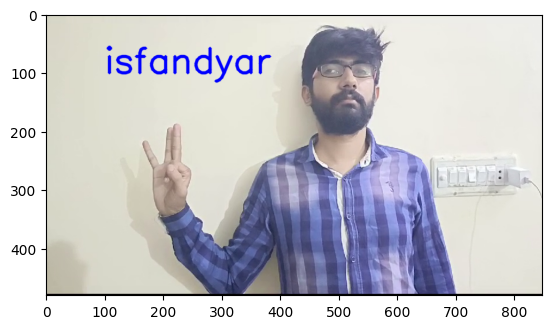

In [3]:
img = cv2.imread('image.png')

# CV2 reads image as BGR, which is needed to be converted into RGB for matplotlib to display it
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
put_text(img,'isfandyar', (100,100))
plt.imshow(img)

### MediaPipe

Downloading Task

In [4]:
#!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

Using MediaPipe to locate the hand and specific points on the hand

c:\Users\HP\anaconda3\envs\mediacv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


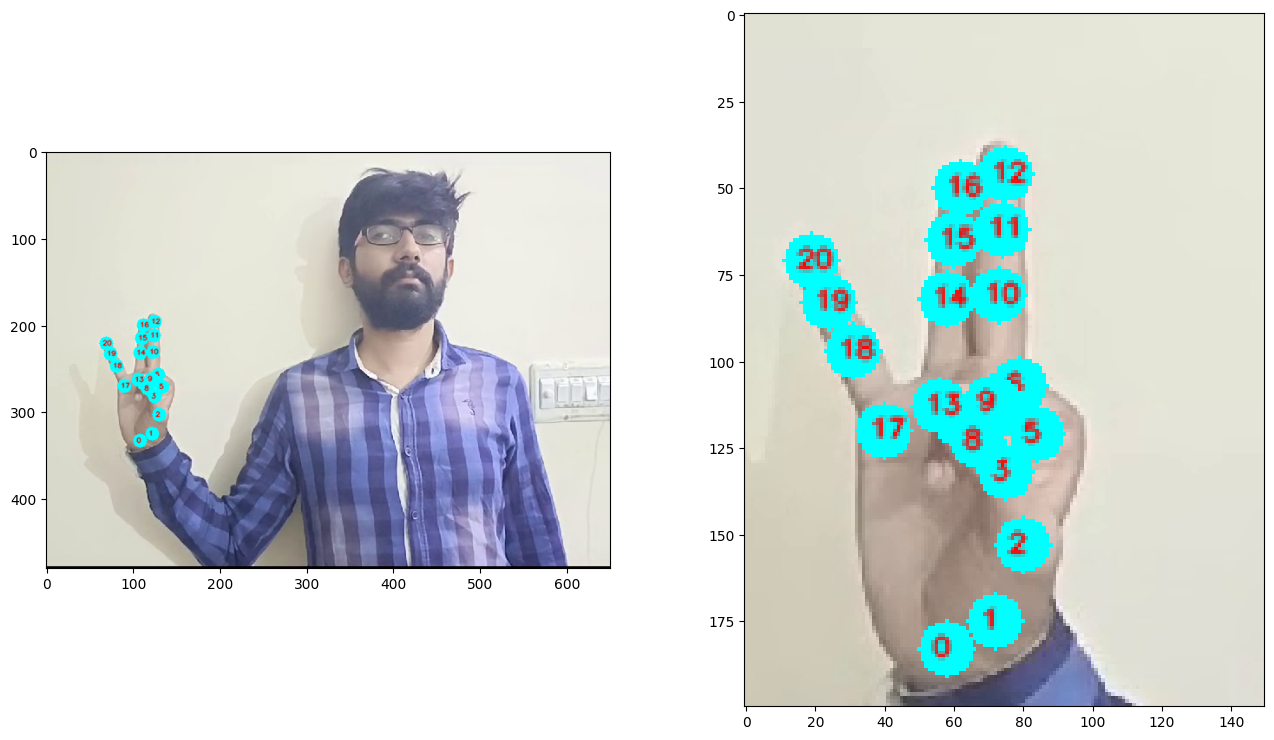

In [5]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Color in the points detected by mediapipe
img = image.numpy_view().copy()
font = cv2.FONT_ITALIC
for i, point in enumerate(detection_result.hand_landmarks[0]):
    x_corr = int(point.x * img.shape[1])
    y_corr = int(point.y * img.shape[0])
    cv2.circle(img, (x_corr, y_corr), 8, color=(0,255,255), thickness=-1)
    cv2.putText(img, text=str(i), org=(x_corr-4, y_corr+2), fontFace=font, fontScale=0.25, color=(255,0,0), thickness=1, lineType=cv2.LINE_AA)
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16,9))
ax0.imshow(img[:,100:750]) 
ax1.imshow(img[150:350,150:300]) 

### Counting Fingers

First we will get the coordinates of the points on the hand. Next we will find the distance between the wrist and the tip of a finger. And then the distance between the wrist and the base of the finger. We will divide the tip distance by the base distance to get a ratio. If the finger is open we expect the ratio to be higher, atleast more than one. If the finger is closed we expect the opposite. We will set a specific threshold and check if the finger ratio crosses it. If it does than we say that partifular finger is open.
$$
    \alpha > \frac{tip \ distance}{base \ distance}
$$

The thumb behaves a little different from the fingers. We divide the ratio  by $\beta$ to make sure that it works with the same threshold.

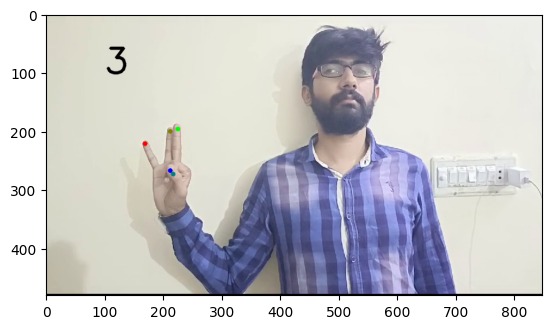

In [6]:
from scipy.spatial.distance import euclidean

# Helper function to transfrom outputs from detector to pixels
def get_coords(coord, xmax, ymax): return int(coord.x * xmax), int(coord.y * ymax)

def finger_count(img, coords, alpha=1.5, beta=2):
    # Get coordinates of different points
    xmax, ymax = img.shape[1], img.shape[0] 
    wrist = get_coords(coords[0], xmax, ymax)
    # The annotated image in the last cell helps us figure out the position of the tips and basses of the fingers 
    bases = [ get_coords(coords[i], xmax, ymax) for i in range(1,21,4) ]
    tips = [ get_coords(coords[i], xmax, ymax) for i in range(4,21,4) ] 

    # Color in circles at the points to verify that our detector is working correctly. 
    colors = [(0,0,255), (0,128,128), (0,255,0), (128,128,0), (256,0,0)] 
    for i,j,c in zip(tips,bases,colors):
        # Only color the tips to avoid clutter
        cv2.circle(img, center=(i), radius=4, color=c, thickness=-1) 
        
    dist_ratios = [ euclidean(i,wrist)/euclidean(j,wrist) for i,j in zip(tips,bases) ]
    dist_ratios[0] /= beta
    dist_ratios = np.array(dist_ratios)>alpha
    n_fingers = dist_ratios.sum()
    '''binary_count = sum( [ finger*(2**power) for power, finger in enumerate(dist_ratios)] )
    cv2.putText(
        img, text=str(binary_count), org=(xmax-150,100), fontFace=font, 
        fontScale=2, color=(0,0,0), thickness=4, lineType=cv2.LINE_AA
    )'''
    cv2.putText(
        img, text=str(n_fingers), org=(100,100), fontFace=font, 
        fontScale=2, color=(0,0,0), thickness=4, lineType=cv2.LINE_AA
    )
    return n_fingers, dist_ratios

img = image.numpy_view().copy()
finger_count(img, detection_result.hand_landmarks[0], beta=3)
plt.imshow(img)

### Counting fingers in a stream

In [7]:
'''cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while True:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
    detection_result = detector.detect(image)
    img = image.numpy_view().copy()
    
    # We want to use the finger counting function only if we already detect a hand in the image
    if len(detection_result.hand_landmarks)!=0:  
        n_fingers, dist_ratios = finger_count(img, detection_result.hand_landmarks[0], alpha=1.3, beta=2.2)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imshow('frame', img)

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()'''

"cap = cv2.VideoCapture(0)\nwidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))\nheight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))\n\nwhile True:\n    ret, frame = cap.read()\n    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)\n    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)\n    detection_result = detector.detect(image)\n    img = image.numpy_view().copy()\n    \n    # We want to use the finger counting function only if we already detect a hand in the image\n    if len(detection_result.hand_landmarks)!=0:  \n        n_fingers, dist_ratios = finger_count(img, detection_result.hand_landmarks[0], alpha=1.3, beta=2.2)\n    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)\n    cv2.imshow('frame', img)\n\n    if cv2.waitKey(1) & 0xFF == 27:\n        break\n\ncap.release()\ncv2.destroyAllWindows()"

### Hand Cricket

In [8]:
class hand_cricket:
    def __init__(self,pl_playing=True):
        self.counter = 0
        self.val = 0
        self.reset = True
        self.last_frames = []
        self.p1 = 0
        self.p2 = 0
        self.p1_playing = pl_playing
    
    def tick(self): self.counter += 1
    def tock(self): 
        self.counter = 0
        self.last_frames = []

    def cal_value(self): self.val = int(np.median(self.last_frames))

    def update_scores(self, randi):
        self.cal_value()
        
        if self.reset:
            if self.val==randi:
                #print('change')
                if self.p1_playing == False: return False
                self.p1_playing = False
                self.val = 0
            if self.val: 
                if self.p1_playing: self.p1 += self.val
                else: self.p2 += randi
                self.reset = False
        if self.val==0: self.reset = True    
        return True         

    def append(self,num:int): self.last_frames.append(num)

In [10]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cricket = hand_cricket()
not_terminate = True

while not_terminate:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
    detection_result = detector.detect(image)
    img = image.numpy_view().copy()
    
    # We want to use the finger counting function only if we already detect a hand in the image
    if len(detection_result.hand_landmarks)!=0:  
        n_fingers, dist_ratios = finger_count(img, detection_result.hand_landmarks[0], alpha=1.3, beta=2.2)
        cricket.append(n_fingers) 
        cricket.tick()
        if cricket.counter==10:
            randi = np.random.randint(5)+1
            not_terminate = cricket.update_scores(randi)  
            put_text(img, cricket.p1, (100,200), color=(0,0,0))
            put_text(img, cricket.p2, (300,200))
            put_text(img, randi, (300,100))
            cricket.tock()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imshow('frame', img)
    if cv2.waitKey(1) & 0xFF == 27:
        break

for i in range(120):
    ret, frame = cap.read()
    if cricket.p1>cricket.p2: put_text(frame, "Player 1 won!!!", (100,100), color=(0,0,0))
    elif cricket.p1<cricket.p2: put_text(frame, "Player 2 won!!!", (100,100), color=(0,0,0))
    else: put_text(frame, "Draw", (100,100), color=(0,0,0))
    cv2.imshow('frame', frame)

cap.release()
cv2.destroyAllWindows()